In [26]:
import numpy as np
import skimage
import joblib
import skimage.feature
from matplotlib import pyplot as plt
from skimage.feature import graycomatrix
from sklearn.cluster import KMeans
import os
import cv2
from skimage import io, color
from skimage.feature import graycoprops
import pandas as pd
from sklearn.utils import shuffle


## Loading the image

In [27]:
def load_images_from_folder(folder):
    images = []
    labels = []

    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)

        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread((img_path), cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    img = cv2.resize(img, (36, 36))  # Resize image to 36 * 36 pixels
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)

imgs_path = '/kaggle/input/eye-diseases-classification/dataset'

gray_images, labels = load_images_from_folder(imgs_path)
gray_images = shuffle(gray_images, random_state=42)

print(gray_images.shape)

(4217, 36, 36)


In [28]:
print(gray_images[0].shape)

(36, 36)


## Doing GLCM

In [29]:
distances = [1, 2, 3, 4, 5]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # worksheet

features_array = []
features_array_normalized = []
# Calculate GLCM
for gray_image in gray_images:
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, normed=True)

    contrast = graycoprops(glcm, prop='contrast')

    dissimilarity = graycoprops(glcm, prop='dissimilarity')

    energy = graycoprops(glcm, prop='energy')

    correlation = graycoprops(glcm, prop='correlation')

    features_array.append(np.array([contrast.flatten(), dissimilarity.flatten(), energy.flatten(), correlation.flatten()]))
    
    features_array_normalized.append(np.array([contrast.flatten() / np.max(glcm), dissimilarity.flatten() / np.max(glcm)
                                    , energy.flatten() / np.max(glcm), correlation.flatten() / np.max(glcm)]))

features_array = np.array(features_array)
features_array_normalized = np.array(features_array_normalized)
print(features_array.shape)
print(features_array_normalized.shape)

(4217, 4, 20)
(4217, 4, 20)


## Fitting Kmeans

In [30]:
features_array = np.array(np.reshape(features_array, (-1,80)))
df = pd.DataFrame(features_array)
print(df.info())
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.labels_ = labels
kmeans.fit(features_array)

print(f'inertia: {kmeans.inertia_}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 80 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4217 non-null   float64
 1   1       4217 non-null   float64
 2   2       4217 non-null   float64
 3   3       4217 non-null   float64
 4   4       4217 non-null   float64
 5   5       4217 non-null   float64
 6   6       4217 non-null   float64
 7   7       4217 non-null   float64
 8   8       4217 non-null   float64
 9   9       4217 non-null   float64
 10  10      4217 non-null   float64
 11  11      4217 non-null   float64
 12  12      4217 non-null   float64
 13  13      4217 non-null   float64
 14  14      4217 non-null   float64
 15  15      4217 non-null   float64
 16  16      4217 non-null   float64
 17  17      4217 non-null   float64
 18  18      4217 non-null   float64
 19  19      4217 non-null   float64
 20  20      4217 non-null   float64
 21  21      4217 non-null   float64
 22  

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


inertia: 17957005722.245594


## silhouette_score

In [31]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(features_array, kmeans.labels_)
print(silhouette_avg)

0.508743815725784


## Visualize the clusters centroids

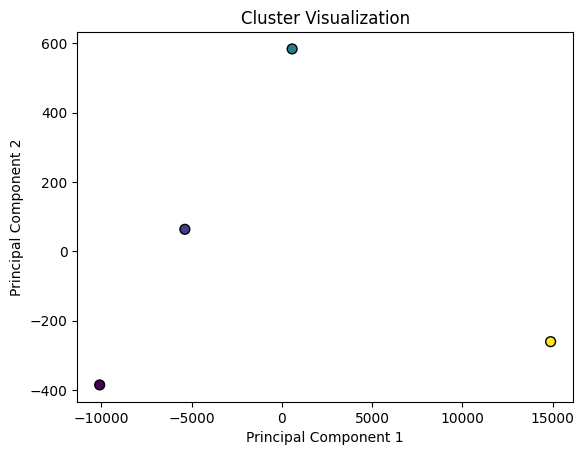

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans.cluster_centers_)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[i for i in X_pca[:, 0]], cmap='viridis', edgecolor='k', s=50)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Visualize features in 2D

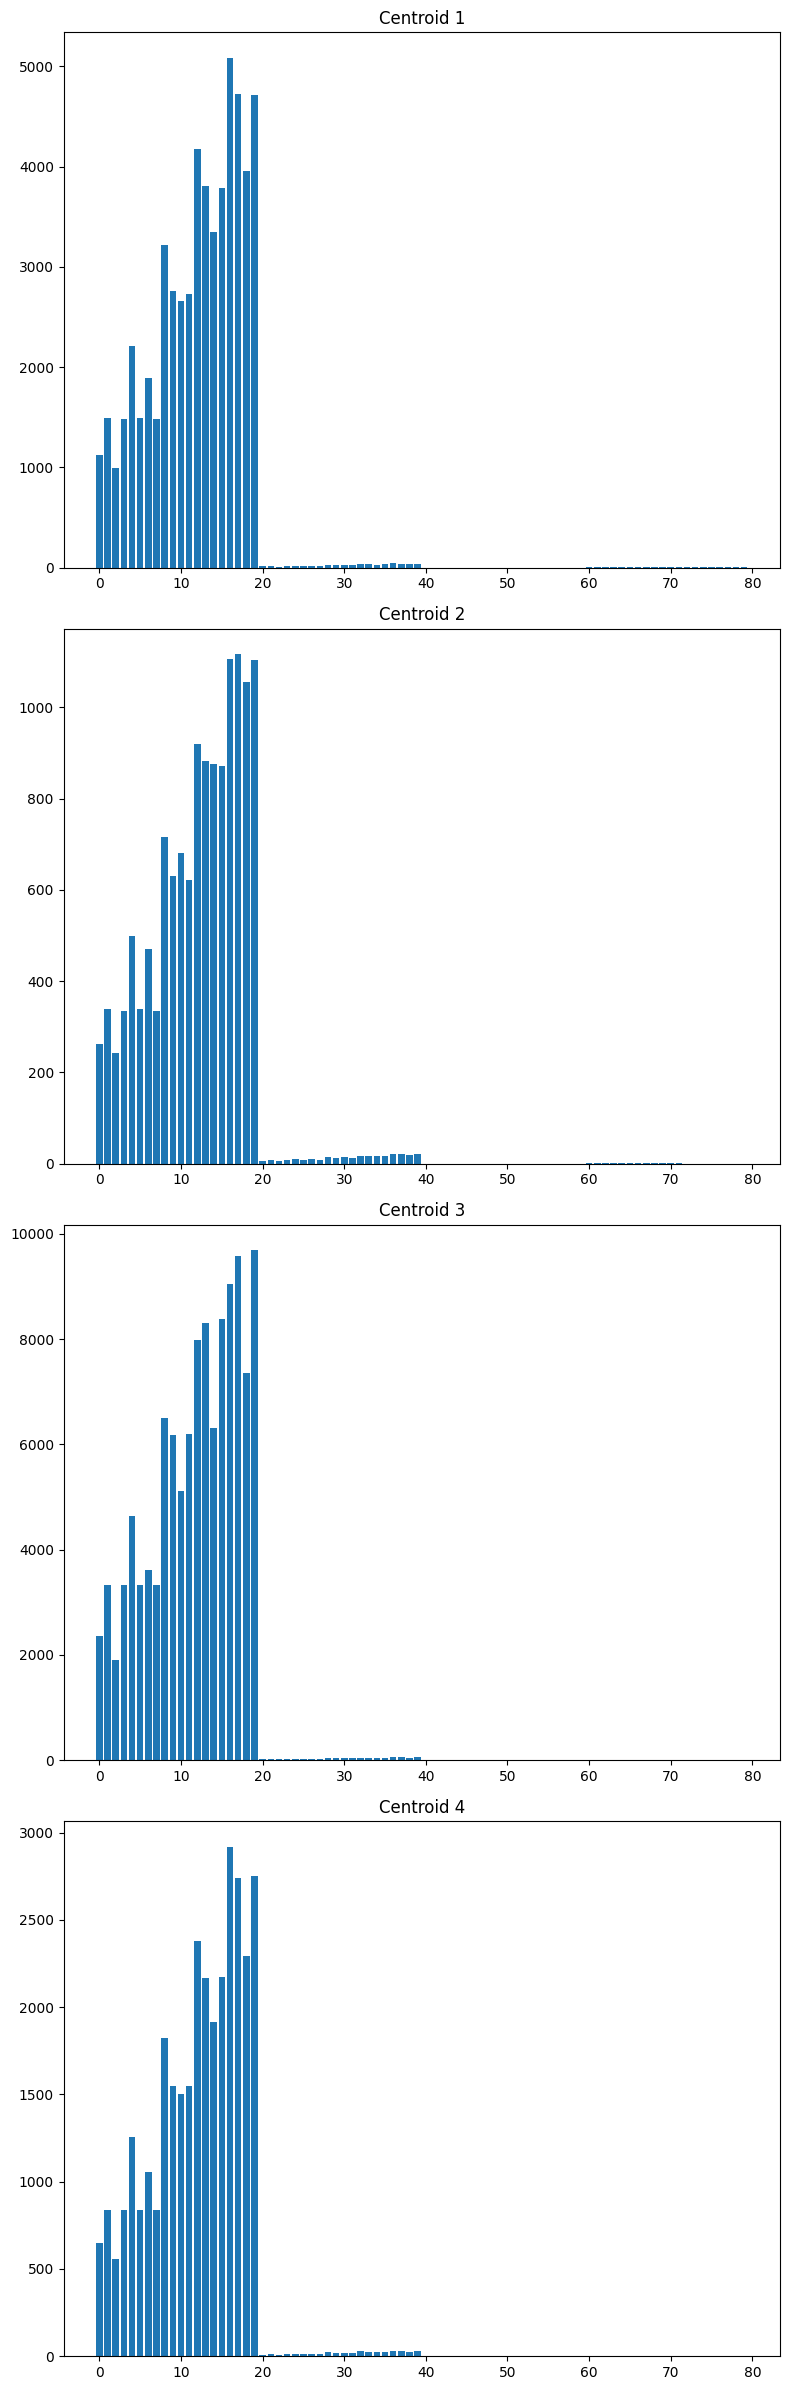

In [33]:
# Assuming you have the centroids as features
centroids = kmeans.cluster_centers_

# Assuming you have feature names for each centroid feature
feature_names = [i for i in range(len(centroids[0]))]  # Replace ... with actual feature names

num_clusters = len(centroids)
num_features = len(centroids[0])

# Plotting centroids as bar charts
fig, axs = plt.subplots(num_clusters, figsize=(8, 24))

for i in range(num_clusters):
    axs[i].bar(feature_names, centroids[i])
    axs[i].set_title(f'Centroid {i+1}')

plt.tight_layout()
plt.show()


## fitting Kmeans_normalized

In [34]:
features_array_normalized = np.array(np.reshape(features_array_normalized, (-1,80)))
df = pd.DataFrame(features_array_normalized)
print(df.info())
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.labels_ = labels
kmeans.fit(features_array_normalized)

print(f'inertia: {kmeans.inertia_}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 80 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4217 non-null   float64
 1   1       4217 non-null   float64
 2   2       4217 non-null   float64
 3   3       4217 non-null   float64
 4   4       4217 non-null   float64
 5   5       4217 non-null   float64
 6   6       4217 non-null   float64
 7   7       4217 non-null   float64
 8   8       4217 non-null   float64
 9   9       4217 non-null   float64
 10  10      4217 non-null   float64
 11  11      4217 non-null   float64
 12  12      4217 non-null   float64
 13  13      4217 non-null   float64
 14  14      4217 non-null   float64
 15  15      4217 non-null   float64
 16  16      4217 non-null   float64
 17  17      4217 non-null   float64
 18  18      4217 non-null   float64
 19  19      4217 non-null   float64
 20  20      4217 non-null   float64
 21  21      4217 non-null   float64
 22  

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


inertia: 11424555667379.357


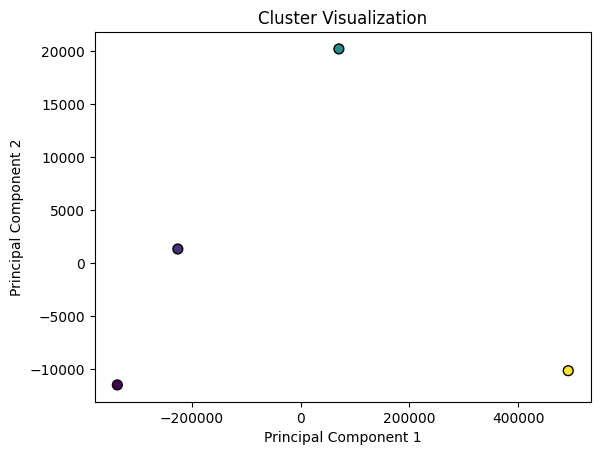

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans.cluster_centers_)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[i for i in X_pca[:, 0]], cmap='viridis', edgecolor='k', s=50)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

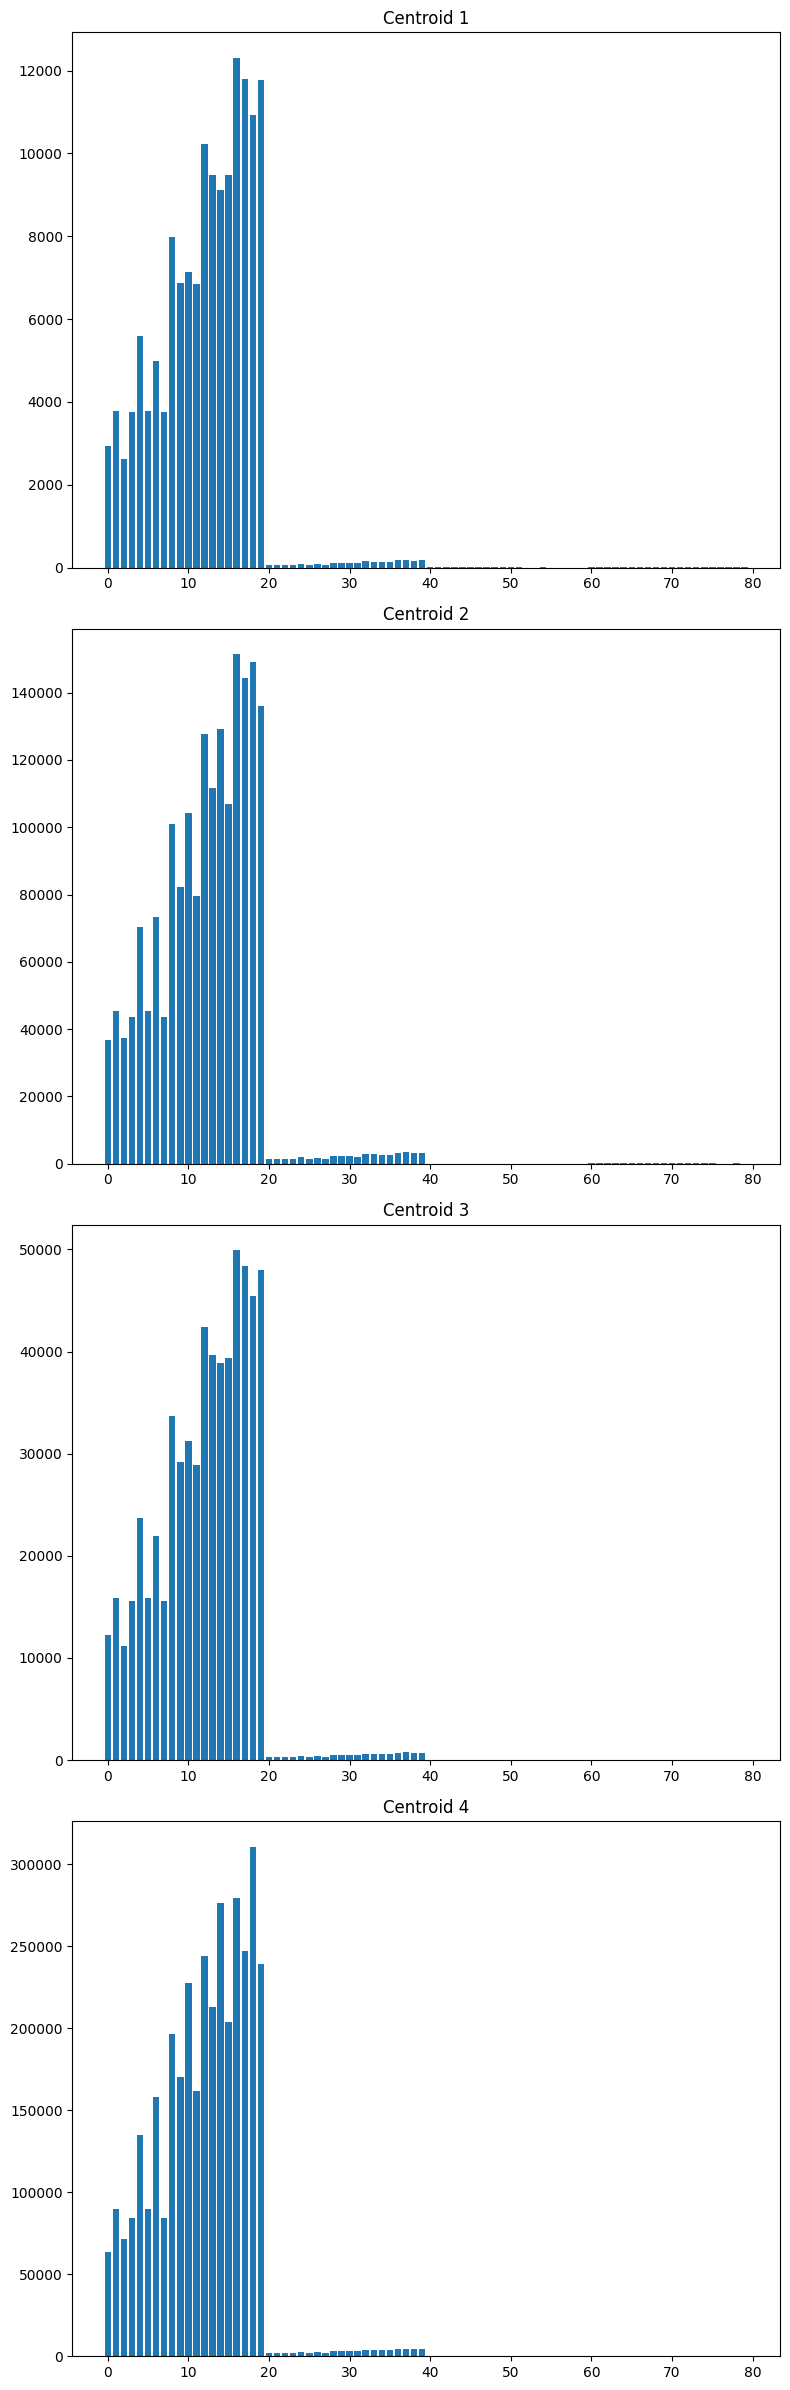

In [36]:
# Assuming you have the centroids as features
centroids = kmeans.cluster_centers_

# Assuming you have feature names for each centroid feature
feature_names = [i for i in range(len(centroids[0]))]  # Replace ... with actual feature names

num_clusters = len(centroids)
num_features = len(centroids[0])

# Plotting centroids as bar charts
fig, axs = plt.subplots(num_clusters, figsize=(8, 24))

for i in range(num_clusters):
    axs[i].bar(feature_names, centroids[i])
    axs[i].set_title(f'Centroid {i+1}')

plt.tight_layout()
plt.show()


In [38]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(features_array_normalized, kmeans.labels_)
print(silhouette_avg)

0.6991654587065078
